In [5]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

from fastai.vision.all import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset


In [6]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [7]:
import numpy as np
import pandas as pd
df = pd.read_csv(path/'train.csv')

In [8]:
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [9]:
df.iloc[:,0]
df.iloc[0]
df['fname']


0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [10]:
dblock = DataBlock()
dsets = dblock.datasets(df)

In [11]:
dsets.train[0]

(fname        002916.jpg
 labels      person sofa
 is_valid           True
 Name: 1460, dtype: object,
 fname        002916.jpg
 labels      person sofa
 is_valid           True
 Name: 1460, dtype: object)

In [12]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('004555.jpg', 'aeroplane')

In [13]:
def get_x(r) : return path/'train'/r['fname']
def get_y(r) : return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/Users/parhamzam/.fastai/data/pascal_2007/train/000285.jpg'),
 ['person', 'chair'])

In [14]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
                      0., 0., 0., 0., 0.]))

dsets.train[0][1] picks the target vector of the first item.

torch.where(... == 1.) returns the indices of the positions that are 1 (i.e., which classes are present).

We take [0] because torch.where returns a tuple, and the first element is the index tensor.

dsets.train.vocab is the mapping from index → class name (built in step 1).

Indexing it with idxs converts those indices back to human-readable labels.

Example output: ['dog'] (or multiple labels if the image has several).

In [15]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#3) ['boat','cow','person']

the splitter gives us the list of integers representing the indexs of tha training set and validation set

In [22]:
def splitter(df):
       train = df.index[~df['is_valid']].tolist()
       valid = df.index[df['is_valid']].tolist()
       return train, valid

In [17]:
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333, ['car'])

In [18]:
dsets.valid

(#2510) [(PILImage mode=RGB size=500x375, ['chair']),(PILImage mode=RGB size=500x333, ['car']),(PILImage mode=RGB size=500x375, ['horse', 'person']),(PILImage mode=RGB size=334x500, ['bicycle']),(PILImage mode=RGB size=500x375, ['cat']),(PILImage mode=RGB size=375x500, ['car']),(PILImage mode=RGB size=336x500, ['dog', 'person']),(PILImage mode=RGB size=500x335, ['train']),(PILImage mode=RGB size=500x375, ['bicycle', 'person']),(PILImage mode=RGB size=500x375, ['tvmonitor'])...]

In [ ]:
dblock =  DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter = splitter,
                   get_x = get_x,
                   get_y = get_y,
                   item_tfms= RandomResizedCrop(128, min_scale=0.35))

dls = dblock.dataloaders(df, bs=64)

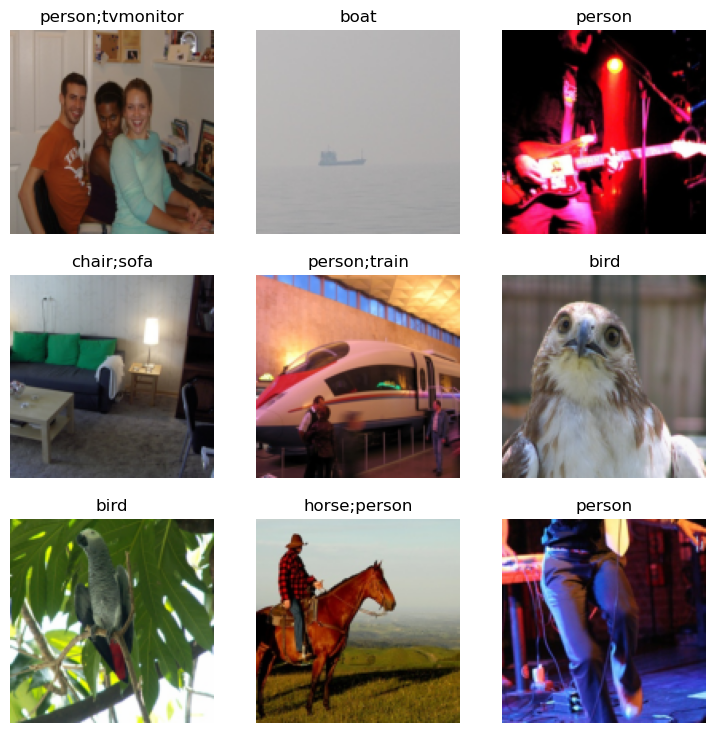

In [26]:
dls.show_batch()

In [27]:
learn = cnn_learner(dls, resnet18)

/Users/parhamzam/miniforge3/envs/mlprojects/lib/python3.8/site-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


In [29]:
learn.model.to('mps')  # 👈 Send model to GPU


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [66]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
learn.model.to(device)

x, y = dls.train.one_batch()
x, y = x.to(device), y.to(device)

actives = learn.model(x)

loss_func = nn.BCEWithLogitsLoss()
loss = learn.loss_func(actives, y)   # fastai-aware loss
print(loss.item())


1.0685290098190308


In [67]:
activs[0].shape

torch.Size([20])

In [68]:
activs[0]

TensorImage([ 5.0787, -1.3620, -0.4566,  3.3545, -1.9457, -0.9457, -0.8029,
              1.6464,  0.5182,  1.5424, -1.6973, -2.7164, -1.1032, -0.3909,
              7.5677,  2.4226,  0.2072, -1.6005,  1.5288, -3.6411],
            device='mps:0', grad_fn=<AliasBackward0>)

In [69]:
def binary_cross_entropy(inputs, targets):
       inputs = inputs.sigmoid()
       return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [71]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
       if sigmoid : inp = inp.sigmoid()
       return ((inp>thresh)==targ.bool()).float().mean()

In [72]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

/Users/parhamzam/miniforge3/envs/mlprojects/lib/python3.8/site-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/parhamzam/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:21<00:00, 4.68MB/s]


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.941497,0.695713,0.227948,00:32
1,0.820942,0.549888,0.287968,00:28
2,0.598748,0.192386,0.831534,00:30
3,0.356188,0.118667,0.946693,00:28


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.129472,0.105970,0.952411,00:34
1,0.113995,0.097134,0.958327,00:34
2,0.097919,0.095051,0.959482,00:34


In [76]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.09505081176757812,0.9434860944747925]

In [77]:
learn.metrics= partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.09505081176757812,0.9432470202445984]

In [79]:
preds, targs = learn.get_preds()
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

tensor(0.9582)

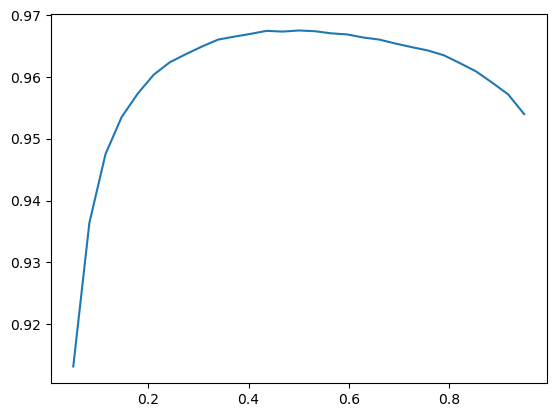

In [80]:
xs = torch.linspace(0.05,0.95, 29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs)